In [44]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Activation,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2,preprocess_input

from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt


## Organizing your Data

In [2]:
Categories = ['yes','no']

In [22]:
os.chdir(r"/mnt/sda2/Final_year_project/btd_final_project/cnn_models/data_2/")
if os.path.isdir("train/yes/") is False:
    os.mkdir('train')
    os.mkdir('test')
    
    for i in Categories:
        shutil.move(f'{i}','train')
        os.mkdir(f'test/{i}')
        
        valid_samples = random.sample(os.listdir(f'train/{i}'),300)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}',f'test/{i}')
        

# Processing Data

In [45]:
train_path = r"/mnt/sda2/Final_year_project/btd_final_project/cnn_models/data_2/train"
test_path = r"/mnt/sda2/Final_year_project/btd_final_project/cnn_models/data_2/test"



In [46]:
train_batches  = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(train_path,target_size=[64,64],batch_size=30)
test_batches  = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(test_path,target_size=[64,64],batch_size=20)

Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


# Building Our Model

In [47]:
# Loading the pre-trained MobileNet Model 
# Including Top Flase : means that we are not going to be using the default classification layers
# we will be removing the default classification layer and adding our own layers 
base_model = MobileNetV2(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(32,activation='relu')(x)
preds = Dense(2,activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=preds)


In [48]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_4[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                         

# Freezing the preTrained Classification Layers

In [49]:
for layers in model.layers[:-5]:
     layers.trainable = False


In [50]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_4[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                         

# Compiling and Fitting the model

In [51]:
epochs = 20 # final

optimizer  = Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

history = model.fit(train_batches,validation_data=test_batches,epochs=epochs)

Epoch 1/20
80/80 [==============================] - 11s 101ms/step - loss: 0.5812 - accuracy: 0.7296 - val_loss: 0.4749 - val_accuracy: 0.7900
Epoch 2/20
80/80 [==============================] - 7s 90ms/step - loss: 0.4045 - accuracy: 0.8462 - val_loss: 0.3629 - val_accuracy: 0.8450
Epoch 3/20
80/80 [==============================] - 7s 90ms/step - loss: 0.3136 - accuracy: 0.8833 - val_loss: 0.3025 - val_accuracy: 0.8783
Epoch 4/20
80/80 [==============================] - 7s 91ms/step - loss: 0.2572 - accuracy: 0.9121 - val_loss: 0.2789 - val_accuracy: 0.8867
Epoch 5/20
80/80 [==============================] - 7s 91ms/step - loss: 0.2159 - accuracy: 0.9237 - val_loss: 0.2546 - val_accuracy: 0.9083
Epoch 6/20
80/80 [==============================] - 7s 91ms/step - loss: 0.1785 - accuracy: 0.9404 - val_loss: 0.2275 - val_accuracy: 0.9117
Epoch 7/20
80/80 [==============================] - 7s 90ms/step - loss: 0.1513 - accuracy: 0.9513 - val_loss: 0.2232 - val_accuracy: 0.9133
Epoch 8/20


In [54]:
def tr_plot(tr_data, start_epoch):
    #Plot the loss and accuracy curve
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'orange', label='Training loss')
    axes[0].plot(Epochs,vloss,'blue',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'orange',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'blue',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout

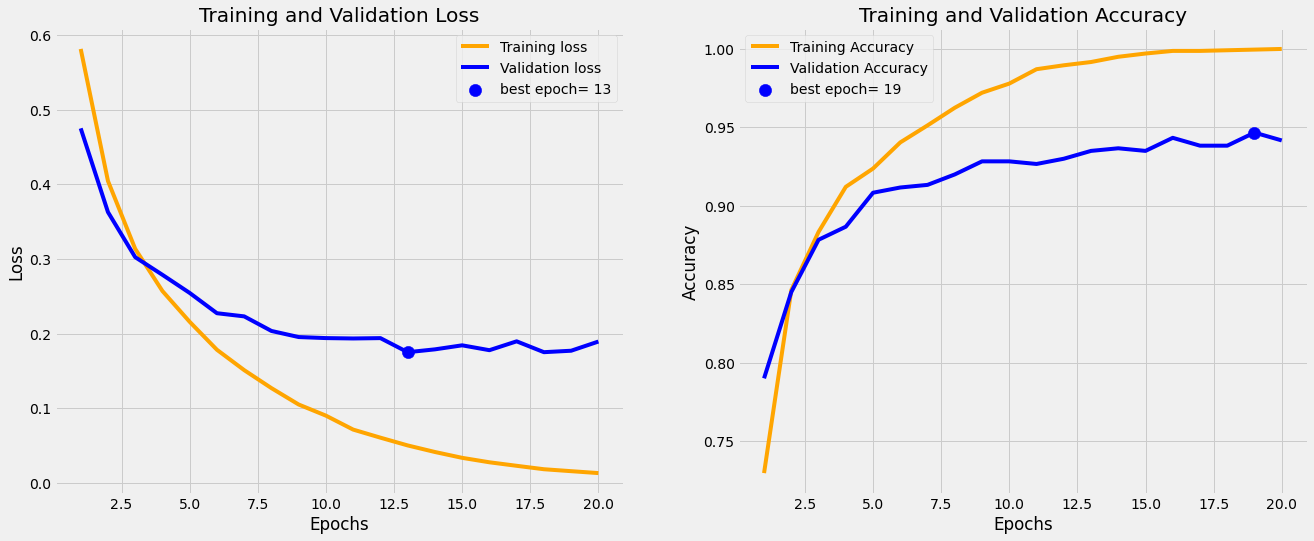

In [55]:
tr_plot(history,0)
plt.savefig('mobileNet_V2_epoch2_20_batch_size_30_final.png')



In [56]:
model.save('BrainTumor_MobileNet_V2_epochs_20_final.h5')

In [40]:
saved_model = tf.keras.models.load_model("./BrainTumor_MobileNet_V2_epochs_20_final.h5")

In [41]:
print(saved_model)

In [ ]:
saved_model.